<a href="https://colab.research.google.com/github/Divyascientist/Predictions/blob/main/cat_v_dog_classifier_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install split-folders

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets,transforms,models
import splitfolders

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


In [5]:


train_transforms= transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms= transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

splitfolders.ratio("/content/drive/MyDrive/data/Cat_Dog_data", output="TrainTest", seed=1337, ratio=(.8, .2))




Copying files: 4 files [00:08,  2.21s/ files]


In [6]:
import os

for dirname, _, filenames in os.walk('TrainTest/train'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

TrainTest/train/Cat/cat1.jpeg
TrainTest/train/Dog/dog1.jpeg


In [7]:
!rm -r TrainTest/train/.ipynb_checkpoints
!rm -r TrainTest/val/.ipynb_checkpoints

In [9]:
train_data = datasets.ImageFolder('TrainTest/train', transform = train_transforms)
test_data = datasets.ImageFolder('TrainTest/val', transform = test_transforms)

In [10]:
trainloader=torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True)
testloader=torch.utils.data.DataLoader(test_data,batch_size=64)

In [11]:
model=models.densenet121(pretrained=True)
model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 164MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [12]:
for param in model.parameters():
  param.requires_grad=False

from collections import OrderedDict
Classifier=nn.Sequential(OrderedDict([
                        ('fc1',nn.Linear(1024,512)),
                        ('relu',nn.ReLU()),
                        ('fc2',nn.Linear(512,256)),
                        ('relu',nn.ReLU()),
                        ('fc3',nn.Linear(256,2)),
                        ('output',nn.LogSoftmax(dim=1))]))

In [13]:
model.classifier=Classifier
model.classifier

Sequential(
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (output): LogSoftmax(dim=1)
)

In [14]:
criterion=nn.NLLLoss()

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [33]:
optimizer=optim.Adam(model.classifier.parameters(),lr=0.003)


epochs = 20



losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


  # loop over epochs
for epoch in range(epochs):


    model.to(device)
    batchAcc  = []
    batchLoss = []
    for X,y in trainloader:
      #X = X.reshape(2,150528) # Reshaping 4D to 2D
      X = X.to(device)
      y = y.to(device)

      ypred =  model(X)
      loss = criterion(ypred,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

      ypred = ypred.cpu()
      y = y.cpu()

      acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
      batchAcc.append(acc)

    trainAcc.append( np.mean(batchAcc) )

    losses[epoch] = np.mean(batchLoss)

    # TESTING


    model.eval()
    with torch.no_grad():

        for X,y in testloader:
            #X = X.reshape(2,150528)
            X = X.to(device)
            y = y.to(device)


            ypred =  model(X)
            ypred = ypred.cpu()
            y = y.cpu()

    testAcc.append( 100*torch.mean((torch.argmax(ypred,axis=1)==y).float()) )
    if (epoch % 5) == 0:
      print(f'epoch: {epoch}   loss: {loss.item()}')





epoch: 0   loss: 1.8477405774319777e-06
epoch: 5   loss: 0.0
epoch: 10   loss: 0.0
epoch: 15   loss: 0.0


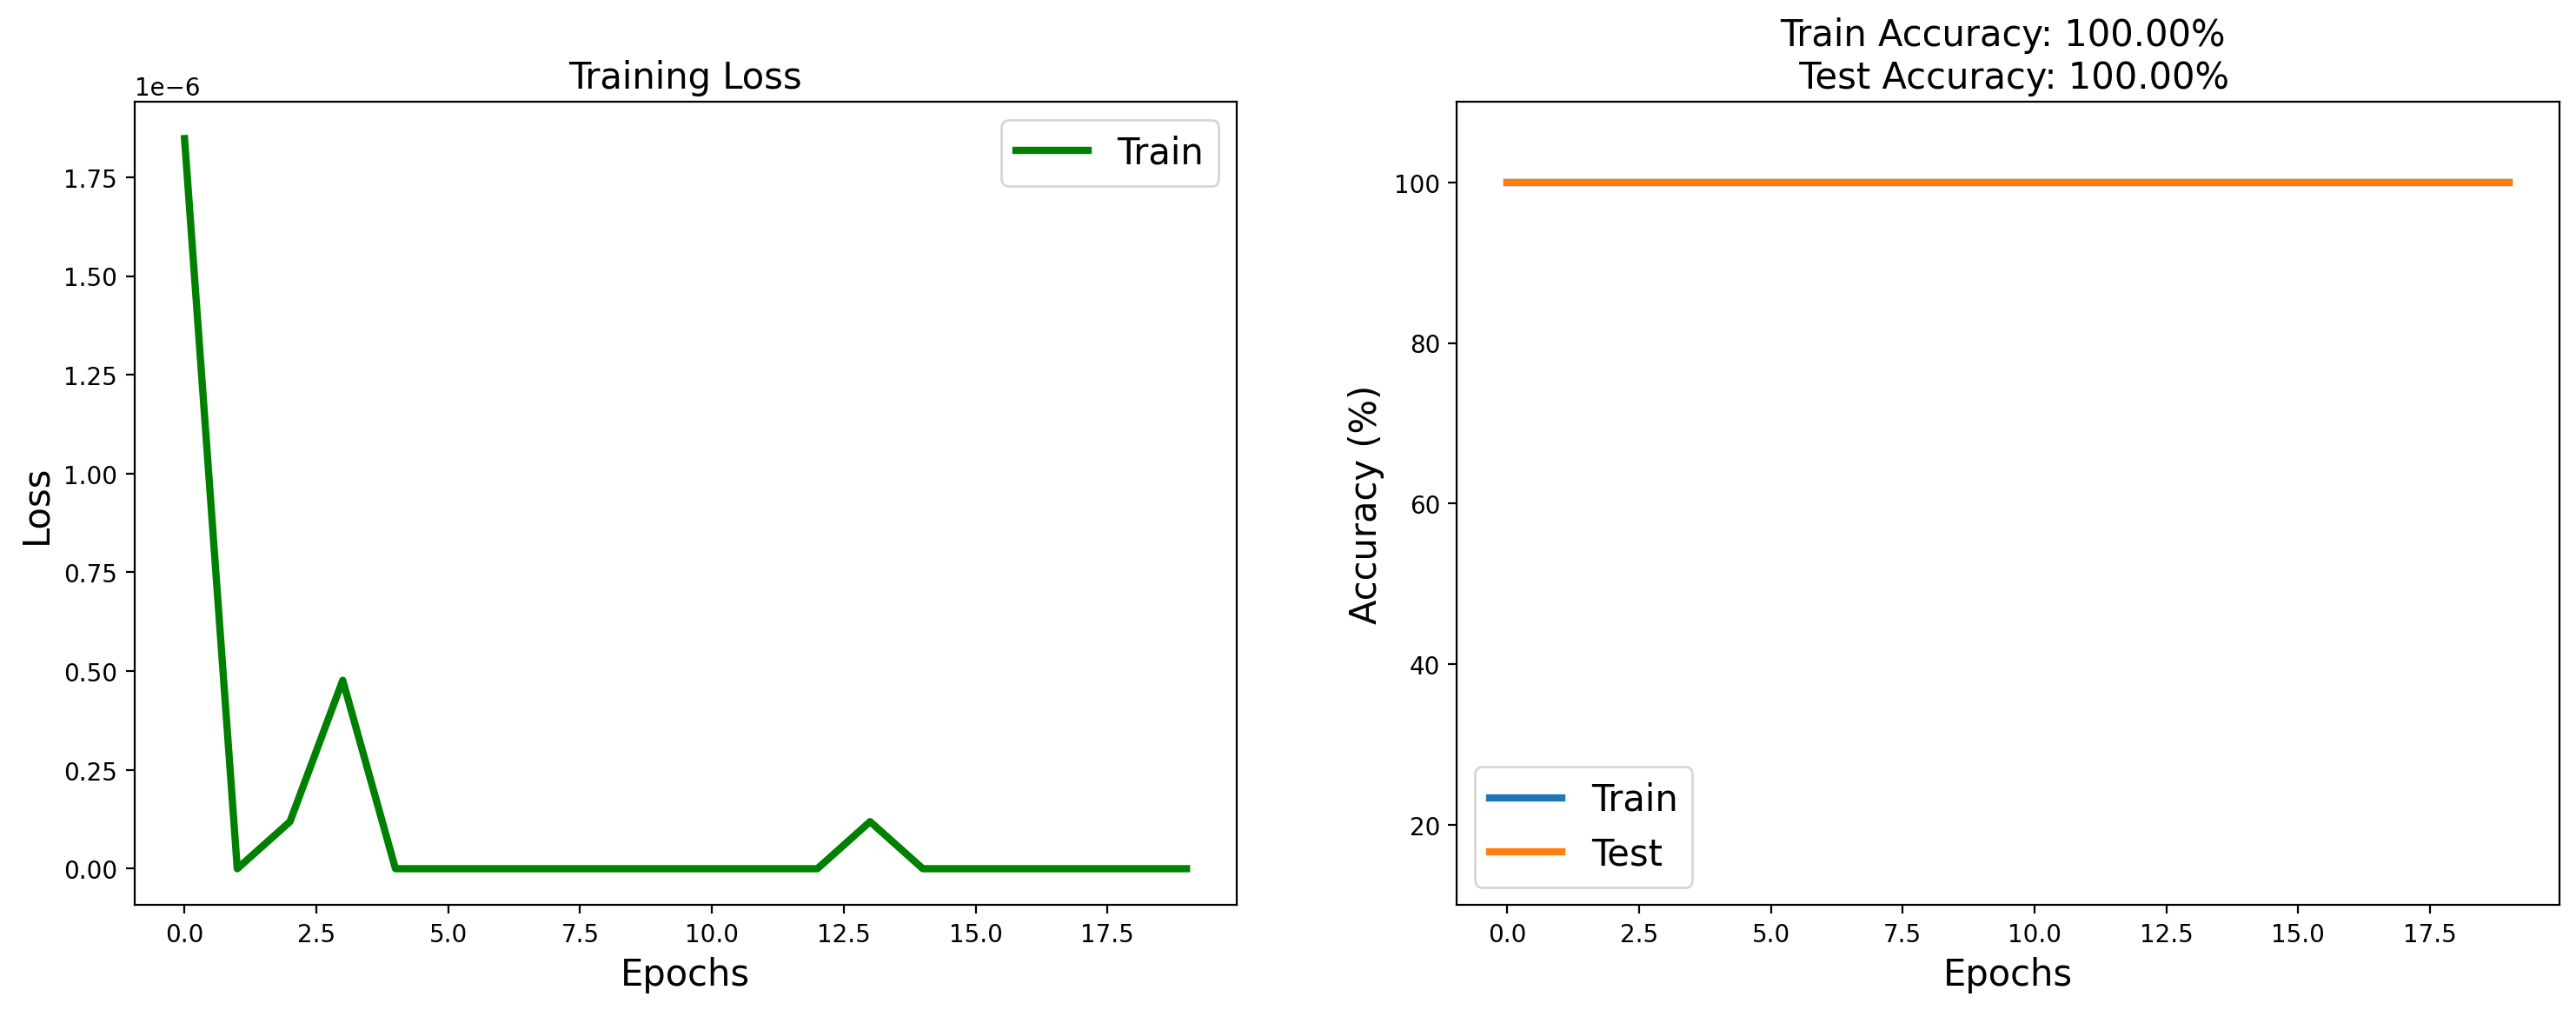

In [34]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(18,6))
ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc,label='Train',lw=3)
ax[1].plot(testAcc,label='Test',lw=3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

In [38]:
checkpoint = {
    'parameters' : model.parameters,
    'state_dict' : model.state_dict()
}
torch.save(checkpoint, './catvdog.pth')